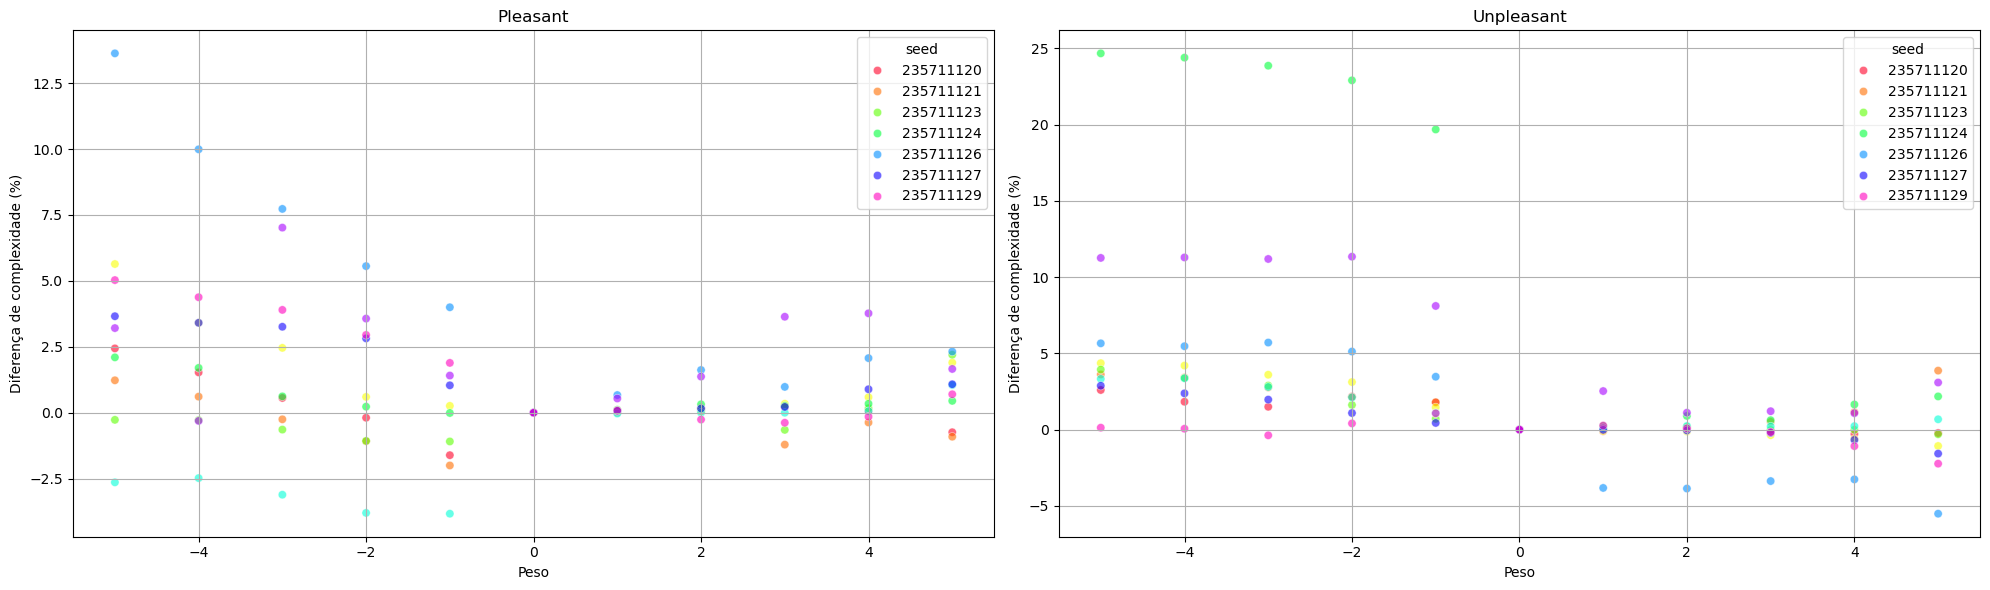

In [1]:
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import os
import re
import seaborn as sns
import numpy as np

# Definindo os diretórios
main_dir = '/home/jerre/git/Stable_Diffusion_IC/colab_images'

pleasant_dirs = [os.path.join(main_dir, 'Pleasant'), os.path.join(main_dir, 'Pleasant+1'), os.path.join(main_dir, 'Pleasant+2'), os.path.join(main_dir, 'Pleasant+3'), os.path.join(main_dir, 'Pleasant+4'), os.path.join(main_dir, 'Pleasant+5'),
                 os.path.join(main_dir, 'Pleasant-1'), os.path.join(main_dir, 'Pleasant-2'), os.path.join(main_dir, 'Pleasant-3'), os.path.join(main_dir, 'Pleasant-4'), os.path.join(main_dir, 'Pleasant-5')]

unpleasant_dirs = [os.path.join(main_dir, 'Unpleasant'), os.path.join(main_dir, 'Unpleasant+1'), os.path.join(main_dir, 'Unpleasant+2'), os.path.join(main_dir, 'Unpleasant+3'), os.path.join(main_dir, 'Unpleasant+4'), os.path.join(main_dir, 'Unpleasant+5'),
                   os.path.join(main_dir, 'Unpleasant-1'), os.path.join(main_dir, 'Unpleasant-2'), os.path.join(main_dir, 'Unpleasant-3'), os.path.join(main_dir, 'Unpleasant-4'), os.path.join(main_dir, 'Unpleasant-5')]

# Função para calcular o ratio de complexidade
def complexity_ratio(img_path, compressed_img_path):
    image = Image.open(img_path)
    image.save(compressed_img_path, optimize=True, quality=95)
    compressed_size = os.path.getsize(compressed_img_path)
    return round((compressed_size / (512 * 512 * 3)) * 100, 2)

# Função para importar imagens
def import_images(directory, dir_type):
    compressed_dir = os.path.join(main_dir, 'compressed')
    if not os.path.exists(compressed_dir):
        os.makedirs(compressed_dir)
    
    images_path = []
    images_weight = []
    images_comp_ratio = []
    images_seed = []

    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp')):
                img_path = os.path.join(root, file)
                compressed_img_path = os.path.join(compressed_dir, f"compressed_{file}")
                comp_ratio = complexity_ratio(img_path, compressed_img_path)
                
                match_seed = re.search(r'S(\d+)', file)
                match_p = re.search(r'leasant\+(\d+)', directory)
                match_n = re.search(r'leasant-(\d+)', directory)

                if dir_type == 'pleasant':
                    if match_p:
                        images_weight.append(int(match_p.group(1)))       
                    elif match_n:
                        images_weight.append(int(match_n.group(1)) * -1)                  
                    else:
                        images_weight.append(0)
                    
                    images_comp_ratio.append(comp_ratio)
                    images_path.append(img_path)
                    images_seed.append(int(match_seed.group(1)) if match_seed else 0)
                else:
                    if match_p:
                        images_weight.append(int(match_p.group(1)))       
                    elif match_n:
                        images_weight.append(int(match_n.group(1)) * -1)                  
                    else:
                        images_weight.append(0)
                    
                    images_comp_ratio.append(comp_ratio)
                    images_path.append(img_path)
                    images_seed.append(int(match_seed.group(1)) if match_seed else 0)
                    
    return images_path, images_weight, images_comp_ratio, images_seed

# Importando imagens
images_path, images_weight, images_comp_ratio, images_seed = [], [], [], []
for dir in pleasant_dirs:
    p_path, p_weight, p_comp_ratio, p_seed = import_images(dir, 'pleasant')
    images_path.extend(p_path)
    images_weight.extend(p_weight)
    images_comp_ratio.extend(p_comp_ratio)
    images_seed.extend(p_seed)

images_path_u, images_weight_u, images_comp_ratio_u, images_seed_u = [], [], [], []
for dir in unpleasant_dirs:
    u_path, u_weight, u_comp_ratio, u_seed = import_images(dir, 'unpleasant')
    images_path_u.extend(u_path)
    images_weight_u.extend(u_weight)
    images_comp_ratio_u.extend(u_comp_ratio)
    images_seed_u.extend(u_seed)

# Dataframe Pleasant
df = pd.DataFrame({'path': images_path, 'weight': images_weight, 'complexity': images_comp_ratio, 'seed': images_seed})
df = df.sort_values(by=['weight'])
df.reset_index(drop=True, inplace=True)

# Dataframe Unpleasant
df2 = pd.DataFrame({'path': images_path_u, 'weight': images_weight_u, 'complexity': images_comp_ratio_u, 'seed': images_seed_u})
df2 = df2.sort_values(by=['weight'])
df2.reset_index(drop=True, inplace=True)

# Calculando diferenças de complexidade
def calculate_diff(df, df_base):
    diff_comp = []
    df_t = df.sort_values(by=['weight', 'seed'])
    df_0 = df_base[['seed', 'weight', 'complexity']]
    df_0 = df_0[df_0['weight'] == 0]

    for index, row in df_t.iterrows():
        seed = row['seed']
        comp = row['complexity']
        
        if seed in df_0['seed'].values:
            complexity_value = df_0.loc[df_0['seed'] == seed, 'complexity'].values[0]
            diff_comp.append(comp - complexity_value)
    
    df_t['diff'] = diff_comp
    return df_t

df_t = calculate_diff(df, df[['seed', 'weight', 'complexity']])
df2_t = calculate_diff(df2, df2[['seed', 'weight', 'complexity']])

# Criando os gráficos
fig, axs = plt.subplots(1, 2, figsize=(20, 6))

sns.scatterplot(data=df_t, x='weight', y='diff', hue='seed', alpha=0.6, palette='gist_rainbow', ax=axs[0])
axs[0].set_title('Pleasant')
axs[0].set_xlabel('Peso')
axs[0].set_ylabel('Diferença de complexidade (%)')
axs[0].grid(True)

sns.scatterplot(data=df2_t, x='weight', y='diff', hue='seed', alpha=0.6, palette='gist_rainbow', ax=axs[1])
axs[1].set_title('Unpleasant')
axs[1].set_xlabel('Peso')
axs[1].set_ylabel('Diferença de complexidade (%)')
axs[1].grid(True)

plt.tight_layout()
plt.savefig('combined_scatter_plot.png', dpi=300)
plt.show()
